In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
import xgboost as xgb

In [4]:
def df_set_options():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)

df_set_options()

In [5]:
def create_dumy(dframe, cols):
    temp_df = pd.get_dummies(dframe, columns = cols)
    return temp_df

In [6]:
def build_lin_model(X, y):
    lr = LinearRegression()
    lr.fit(X, y)
    return lr

def predict_rmse(model, X, y):
    temp_pred = model.predict(X)
    return sqrt(mean_squared_error(y, temp_pred))

def generate_prediction_excel(pred, col, filename = "Predicted_value_file.xlsx"):
    pd.DataFrame(pred, columns=[col]).to_excel(filename)
    print("File "+filename+" created")

In [7]:
train_df = pd.read_excel("G:\MachineHack/Predict_Book_Price/Participants_Data/Data_Train.xlsx")
test_df = pd.read_excel("G:\MachineHack/Predict_Book_Price/Participants_Data/Data_Test.xlsx")

In [7]:
train_df.head()
test_df.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory
0,The Complete Sherlock Holmes: 2 Boxes sets,Sir Arthur Conan Doyle,"Mass Market Paperback,- 1 Oct 1986",4.4 out of 5 stars,960 customer reviews,A collection of entire body of work of the She...,Short Stories (Books),"Crime, Thriller & Mystery"
1,Learn Docker - Fundamentals of Docker 18.x: Ev...,Gabriel N. Schenker,"Paperback,- Import, 26 Apr 2018",5.0 out of 5 stars,1 customer review,Enhance your software deployment workflow usin...,Operating Systems Textbooks,"Computing, Internet & Digital Media"
2,Big Girl,Danielle Steel,"Paperback,- 17 Mar 2011",5.0 out of 5 stars,4 customer reviews,"'Watch out, world. Here I come!'\nFor Victoria...",Romance (Books),Romance
3,Think Python: How to Think Like a Computer Sci...,Allen B. Downey,"Paperback,- 2016",4.1 out of 5 stars,11 customer reviews,"If you want to learn how to program, working w...",Programming & Software Development (Books),"Computing, Internet & Digital Media"
4,Oxford Word Skills: Advanced - Idioms & Phrasa...,Redman Gairns,"Paperback,- 26 Dec 2011",4.4 out of 5 stars,9 customer reviews,"Learn and practise the verbs, prepositions and...",Linguistics (Books),"Language, Linguistics & Writing"


In [8]:
train_df.shape
test_df.shape

(1560, 8)

In [14]:
train_df.describe()

,Price
count,6237.000000
mean,560.707516
std,690.110657
min,25.000000
25%,249.180000
50%,373.000000
75%,599.000000
max,14100.000000


In [8]:
test_df['Price'] = np.nan

In [9]:
df = pd.concat([train_df, test_df], ignore_index=True)

In [17]:
df.shape

(7797, 9)

In [18]:
df.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,- 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,- 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,- 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,- 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,- 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62


In [10]:
df1 = df

In [11]:
# Using regex to remove substring "customer review(s)"
df1["Ratings"].replace(regex=True, inplace = True, to_replace = "customer reviews", value="")
df1["Ratings"].replace(regex=True, inplace = True, to_replace = "customer review", value="")
df1["Ratings"].replace(regex=True, inplace = True, to_replace = ",", value="")
df["Ratings"] = df1["Ratings"].astype(int)

In [12]:
# Removing "out of 5 starts" from Reviews
df1["Reviews"].replace(regex=True, inplace = True, 
                       to_replace = "out of 5 stars", value="")

df1["Reviews"] = df1["Reviews"].astype(float)

In [13]:
df1.describe()

,Reviews,Ratings,Price
count,7797.000000,7797.000000,6237.000000
mean,4.295845,35.520841,560.707516
std,0.663513,153.020897,690.110657
min,1.000000,1.000000,25.000000
25%,4.000000,2.000000,249.180000
50%,4.400000,6.000000,373.000000
75%,4.800000,21.000000,599.000000
max,5.000000,6090.000000,14100.000000


In [14]:
df2 = df1

In [15]:
# Extracting the covertype from "Edition" and creating a new column "CoverType"
df2["CoverType"] = df2["Edition"].str.split(",-", expand=True)[0]

In [16]:
df3 = df2

In [17]:
edition_type = []
for edition in df3["Edition"].str.split(",-", expand=True)[1].str.split(", "):
#    print(edition)
    if len(edition) == 1:
        edition_type.append("Normal")
    else:
        edition_type.append(edition[0].lstrip(" "))

print(edition_type)


['Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Import', 'Normal', 'Normal', 'Normal', 'Import', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Import', 'Normal', 'Normal', 'Normal', 'Deckle Edge', 'Normal', 'Box set', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Import', 'Normal', 'Import', 'Normal', 'Import', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'International Edition', 'Normal', 'Normal', 'Normal', 'Normal', 'Import', 'Normal', 'Normal', 'Normal', 'Normal', 'Unabridged', 'Special Edition', 'Normal', 'Normal', 'International Edition', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Import', 'Import', 'Import', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 

In [18]:
df3["EditionType"] = edition_type

In [28]:
df3.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,CoverType,EditionType
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,- 10 Mar 2016",4.0,8,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00,Paperback,Normal
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,- 7 Nov 2012",3.9,14,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,Paperback,Normal
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,- 25 Feb 1982",4.8,6,"""During the time men live without a common Pow...",International Relations,Humour,299.00,Paperback,Normal
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,- 5 Oct 2017",4.1,13,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,Paperback,Normal
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,- 10 Oct 2006",5.0,1,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62,Hardcover,Normal


In [31]:
df3["CoverType"].value_counts()
df3["EditionType"].value_counts()

Normal                   6808
Import                    773
Illustrated                70
Unabridged                 23
Special Edition            21
Abridged                   20
Student Edition            16
International Edition      14
Box set                    13
Large Print                 9
Audiobook                   8
Deckle Edge                 8
Print                       4
Facsimile                   3
Kindle eBook                2
Deluxe Edition              1
EveryBook                   1
ADPCM                       1
DVD                         1
Bargain Price               1
Name: EditionType, dtype: int64

In [19]:
df3["EditionType"] = df3["EditionType"].str.lstrip(" ")
df3["EditionType"].value_counts()

Normal                   6808
Import                    773
Illustrated                70
Unabridged                 23
Special Edition            21
Abridged                   20
Student Edition            16
International Edition      14
Box set                    13
Large Print                 9
Deckle Edge                 8
Audiobook                   8
Print                       4
Facsimile                   3
Kindle eBook                2
ADPCM                       1
Deluxe Edition              1
DVD                         1
Bargain Price               1
EveryBook                   1
Name: EditionType, dtype: int64

In [34]:
df3.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,CoverType,EditionType
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,- 10 Mar 2016",4.0,8,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00,Paperback,Normal
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,- 7 Nov 2012",3.9,14,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,Paperback,Normal
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,- 25 Feb 1982",4.8,6,"""During the time men live without a common Pow...",International Relations,Humour,299.00,Paperback,Normal
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,- 5 Oct 2017",4.1,13,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,Paperback,Normal
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,- 10 Oct 2006",5.0,1,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62,Hardcover,Normal


Now we have extracted editiontype and covertype from the the column edition. There is "year" in the edition column which can be extracted and can be used and the publication year (Assuming it to be the publication year).

In the below cells we try to extract year. Lets see how it goes.

In [20]:
# df3[df3["Edition"].str.split(" ", expand=True)[7].isna() == False]
# df3["Edition"].str.split(",-", expand=True)
df3[df3["Edition"].str.slice(start=-4).str.isdigit() == False]

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,CoverType,EditionType
169,Long Walk to Freedom: Illustrated Children's e...,Nelson Mandela,"Paperback,- Abridged, Import",5.0,2,Long Walk to Freedom by Nelson Mandela is the ...,Action & Adventure (Books),Action & Adventure,418.0,Paperback,Abridged
235,Alfred's Basic Adult All-in-One Course: Lesson...,Willard A. Palmer,"Plastic Comb,- DVD, NTSC",3.9,6,Alfred's Basic Adult All-in-One Course is a gr...,Music Books,"Arts, Film & Photography",1453.0,Plastic Comb,DVD
582,Fundamentals of Drawing Portraits: A Practical...,Barrington Barber,"Paperback,- Illustrated, Import",4.0,7,This book is essential for everyone who wants ...,"Handicrafts, Decorative Arts & Crafts (Books)","Arts, Film & Photography",415.0,Paperback,Illustrated
972,"Cartooning, The Professional Step-by-Step Guid...","Ivan Hissey, Curtis Tappenden","Paperback,- Illustrated, Import",3.0,1,A comprehensive and practical guide to drawing...,"Handicrafts, Decorative Arts & Crafts (Books)",Comics & Mangas,445.0,Paperback,Illustrated
1233,Amma Tell Me About Raksha Bandhan!,Bhakti Mathur,"Paperback,- Large Print, Import",5.0,1,A promise to love and to protect\nIs sealed by...,Action & Adventure (Books),Action & Adventure,277.0,Paperback,Large Print
1558,Figure it out for Yourself,James Hadley Chase,"Hardcover,- Import, Facsimile",5.0,1,Serena Marshland was the fourth richest woman ...,"Crime, Thriller & Mystery (Books)","Crime, Thriller & Mystery",100.0,Hardcover,Import
1605,"An Introduction to Linguistics: Language, Gram...",Syal,"Paperback,- Abridged, Audiobook, Box set",4.1,29,"This compact and engagingly elegant text, now ...",Engineering,"Language, Linguistics & Writing",399.0,Paperback,Abridged
1631,Swimming: Swimming Made Easy: Beginner and Exp...,Ace McCloud,"Paperback,- Large Print, Import",4.0,1,Are you tired of being a weak swimmer? Do less...,"Swimming, Snorkelling & Diving (Books)",Sports,709.0,Paperback,Large Print
1643,The Merchant of Venice (Text with Paraphrase) ...,William Shakespeare,"Paperback,- Student Edition, Special Edition",3.9,58,Introduce the students to William Shakespeare’...,Theater,"Arts, Film & Photography",220.0,Paperback,Student Edition
1769,The Human Face of Big Data,Rick Smolan,"Hardcover,- Abridged, Audiobook, Box set",5.0,1,The images and stories captured in The Human F...,Computer Science Books,"Computing, Internet & Digital Media",2248.0,Hardcover,Abridged


OK... So We are able to extract year from the "Edition" column. But there are around 30 records in which year is not provided. Looking at the records, we see that there are 9 records from the test data as well which does not have year.

One way I can think of to deal with these records is to provide mean of years as year to these records. Now sure how it will work out but we can try it out.

In [21]:
publishYear = df3["Edition"].str.slice(start=-4)
# round(publishYear[publishYear.str.isdigit() == True].astype(int).mean())

publishYear[publishYear.str.isdigit() == False] = round(publishYear[publishYear.str.isdigit() == True].astype(int).mean())
# type(publishYear[publishYear.str.contains("set")][1605])

df3["PublishYear"] = publishYear.astype(int)

In [22]:
df3["PublishYear"].unique()

array([2016, 2012, 1982, 2017, 2006, 2009, 2018, 2015, 2013, 1999, 2002,
       2011, 1991, 2014, 1989, 2000, 2005, 2019, 2008, 2004, 2010, 2007,
       2001, 1969, 1993, 1992, 2003, 1996, 1997, 1995, 1987, 1986, 1990,
       1988, 1981, 1976, 1994, 1998, 1977, 1974, 1983, 1971, 1985, 1978,
       1964, 1984, 1980, 1979, 1960, 1970, 1975, 1905, 1900, 1961, 1925,
       1973, 1942, 1972], dtype=int64)

In [149]:
df3.head()
# df3.describe()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,CoverType,EditionType,PublishYear
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,- 10 Mar 2016",4.0,8,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00,Paperback,Normal,2016
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,- 7 Nov 2012",3.9,14,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,Paperback,Normal,2012
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,- 25 Feb 1982",4.8,6,"""During the time men live without a common Pow...",International Relations,Humour,299.00,Paperback,Normal,1982
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,- 5 Oct 2017",4.1,13,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,Paperback,Normal,2017
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,- 10 Oct 2006",5.0,1,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62,Hardcover,Normal,2006


In [162]:
# temp = df3["Genre"].value_counts() <10
# genre = list(temp[temp == True].index)
# genre

In [23]:
df4 = create_dumy(df3, ["CoverType", "EditionType", "BookCategory"])
df4.shape

(7797, 60)

In [24]:
df5 = df4.drop(["Title", "Author", "Edition", "Synopsis", "Genre"], axis=1)
df5.shape

(7797, 55)

In [25]:
train_df = df5.loc[df5["Price"].isna() == False]
test_df  = df5.loc[df5["Price"].isna() == True]

test_df.drop(["Price"], inplace=True, axis=1)

X_train_df = train_df.drop(["Price"], axis=1)
Y_train_df = train_df["Price"]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train_df, Y_train_df, test_size=0.20, random_state=42)

In [166]:
lr = build_lin_model(X_train, Y_train)

In [183]:
rmse = predict_rmse(lr, X_test, Y_test)
rmse

607.1296835091974

In [179]:
pred = lr.predict(test_df).astype(int)

In [181]:
generate_prediction_excel(pred, ["Price"], "Prediction_3.xlsx")

File Prediction_3.xlsx created


With Prediction_3.xlsx, the score came as 0.67513, earlier score was 0.67531.
So it seems that the year being used as continuous variable did not help 

In [186]:
log_reg = LogisticRegression()
log_reg.fit(X_train, (Y_train).astype(int))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [188]:
rmse = predict_rmse(log_reg, X_test, (Y_test).astype(int))
rmse

677.1517164678714

In [205]:
log_reg = LogisticRegression(random_state=42, max_iter=500, penalty='l2', solver='lbfgs')
log_reg.fit(X_train, (Y_train).astype(int))
rmse = predict_rmse(log_reg, X_test, (Y_test).astype(int))
rmse

669.9649292390285

In [206]:
pred = log_reg.predict(test_df).astype(int)
generate_prediction_excel(pred, ["Price"], "Prediction_4.xlsx")

File Prediction_4.xlsx created


0.66409

In [207]:
train_sizes = [1, 100, 500, 1000, 2000, 3264]
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
estimator = LinearRegression(),
X = X_train,
y = (Y_train).astype(int), train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error')

In [208]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 1           -0.000000
100     143246.325551
500     364702.092241
1000    366610.297881
2000    365928.603368
3264    374372.422788
dtype: float64

 --------------------

Mean validation scores

 1       558400.174339
100     479432.873098
500     423165.263609
1000    417358.205593
2000    414948.744053
3264    414793.110086
dtype: float64


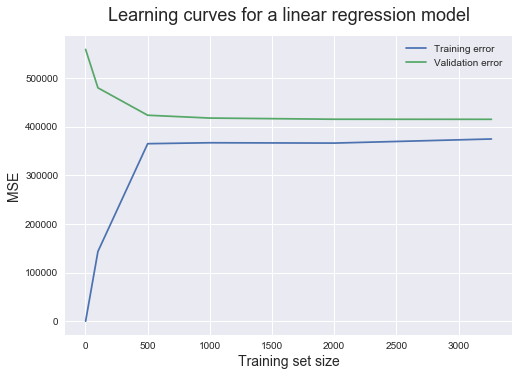

In [209]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()

In [216]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [217]:
xg_reg.fit(X_train,Y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [218]:
preds = xg_reg.predict(X_test)

In [219]:
sqrt(mean_squared_error(Y_test, preds))

658.2613369123386

In [220]:
preds = xg_reg.predict(test_df)

In [221]:
generate_prediction_excel(preds, ["Price"], "Prediction_5.xlsx")

File Prediction_5.xlsx created


With XGBoost I am able to achieve score - 0.70798

In [27]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
linear_reg = LinearRegression()
logistic_reg = LogisticRegression(random_state=42, max_iter=500, penalty='l2', solver='lbfgs')

In [28]:
intermediate_data_df = pd.DataFrame({'linear_reg':np.zeros(X_train_df.shape[0]),
                                    'logistic_reg':np.zeros(X_train_df.shape[0]),
                                    'xg_reg':np.zeros(X_train_df.shape[0])})
intermediate_data_df.head()

,linear_reg,logistic_reg,xg_reg
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [31]:
from sklearn.model_selection import KFold
kfold_partitions = KFold(n_splits=3)
    

In [30]:
fold_number = 1
for train,test_part in kfold_partitions.split(X_train_df):
    column_number = 0
    for algo in [linear_reg, logistic_reg, xg_reg]:
        print(algo)
        print("Fold number: " + str(fold_number))
        print("algo_number: " + str(column_number))
        new_train_X = X_train_df.iloc[train]
        new_train_Y = Y_train_df.iloc[train]
        
        new_test_X = X_train_df.iloc[test_part]
        new_test_Y = Y_train_df.iloc[test_part]
        
        algo.fit(new_train_X,new_train_Y.astype(int))
        algo_pred = algo.predict(new_test_X)
        
        intermediate_data_df.iloc[test_part,column_number] = algo_pred
        column_number = column_number+1
    
    
    fold_number = fold_number+ 1

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Fold number: 1
algo_number: 0
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)
Fold number: 1
algo_number: 1
XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)
Fold number: 1
algo_number: 2
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Fold number: 2
algo_number: 0
Logi

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)
Fold number: 2
algo_number: 2
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Fold number: 3
algo_number: 0
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)
Fold number: 3
algo_number: 1


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)
Fold number: 3
algo_number: 2
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Fold number: 4
algo_number: 0
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)
Fold number: 4
algo_number: 1


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)
Fold number: 4
algo_number: 2
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Fold number: 5
algo_number: 0
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)
Fold number: 5
algo_number: 1


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)
Fold number: 5
algo_number: 2


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [33]:
intermediate_data_df.head()

,linear_reg,logistic_reg,xg_reg
0,307.524435,399.0,297.567627
1,230.322971,399.0,293.991089
2,711.294277,449.0,361.648071
3,292.578952,299.0,263.681763
4,1279.950464,484.0,662.134949


In [34]:
new_x_variables = intermediate_data_df.copy()

In [35]:
new_linear_reg = LinearRegression()
new_linear_reg.fit(new_x_variables,Y_train_df)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [36]:
new_linear_reg.coef_

array([0.3794523 , 0.20724515, 1.76063394])

In [47]:
Y_predict_testprob_linr1 = linear_reg.predict(test_df)
Y_predict_testprob_logr1 = logistic_reg.predict(test_df)
Y_predict_testprob_xgb1 = xg_reg.predict(test_df)

In [48]:
test_input_x_var = pd.DataFrame({'linear_reg': Y_predict_testprob_linr1,
                                 'logistic_reg': Y_predict_testprob_logr1,
                                 'xg_reg': Y_predict_testprob_xgb1})

In [49]:
Y_pred_fina_testprob_ensemble = new_linear_reg.predict(test_input_x_var)

In [51]:
len(Y_pred_fina_testprob_ensemble)

1560

In [41]:
train_sizes = [1, 100, 500, 1000, 2000, 3264]
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
estimator = LinearRegression(),
X = new_x_variables,
y = (Y_train_df).astype(int), train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error')

In [42]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 1           -0.000000
100     197312.382019
500     248788.593310
1000    356166.036135
2000    355538.258521
3264    404737.762983
dtype: float64

 --------------------

Mean validation scores

 1       595594.875034
100     432549.335910
500     395797.041878
1000    396129.927034
2000    394398.751034
3264    394485.520532
dtype: float64


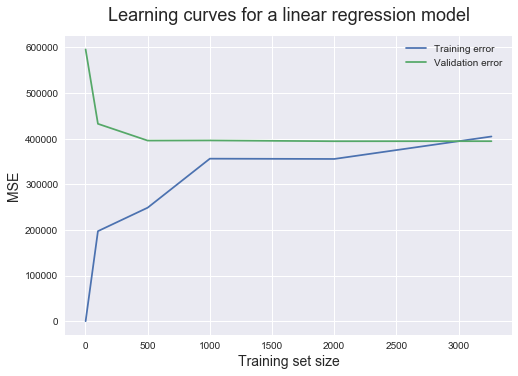

In [43]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()

In [52]:
generate_prediction_excel(Y_pred_fina_testprob_ensemble, ["Price"], "Prediction_6.xlsx")

File Prediction_6.xlsx created


In [46]:
len(Y_pred_fina_testprob_ensemble)
test_input_x_var.shape

(1248, 3)